[View in Colaboratory](https://colab.research.google.com/github/3catz/time_series_LSTMS/blob/master/Chen_Chaotic_Attractor_Time_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb)

#Chen Chaotic Attractor -  Time Series Analysis using EMD and Dilated Convolutional Neural Networks
You can find a list of [chaotic maps here. ](https://en.wikipedia.org/wiki/List_of_chaotic_maps)

This is a three dimensional system but I am using one dimension only, creating a univariate time series for the purposes of this experiment. 

In [1]:
!pip install pyhht
!pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
import peakutils
#!pip install pyramid-arima
#from pyramid.arima import auto_arima

Using TensorFlow backend.


# Utilities: series to supervised

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [3]:
from google.colab import files    
files.upload()




Saving chensystem.csv to chensystem.csv


{'chensystem.csv': b'7.8962,10.452,13.519,16.508,17.961,15.952,10.025,2.4037,-4.2574,-8.982,-11.797,-12.642,-11.345,-8.2064,-4.2018,-0.38919,2.6934,5.0291,6.8169,8.2411,9.3788,10.185,10.521,10.237,9.277,7.7622,5.9687,4.2024,2.6778,1.4755,0.5722,-0.10984,-0.66569,-1.192,-1.787,-2.5605,-3.6503,-5.242,-7.5807,-10.934,-15.381,-20.144,-22.475,-18.252,-7.3506,4.4007,12.67,16.557,15.389,9.3635,1.3123,-5.521,-9.8621,-11.621,-10.882,-8.0754,-4.2229,-0.45201,2.6106,4.8851,6.543,7.7693,8.6695,9.2611,9.5012,9.3345,8.7492,7.8153,6.6805,5.5245,4.5025,3.7133,3.2003,2.9728,3.0316,3.3905,4.0916,5.2149,6.8805,9.2236,12.295,15.788,18.54,18.33,13.411,5.1708,-2.9079,-8.8465,-12.401,-13.475,-11.835,-7.9189,-3.09,1.2938,4.6545,7.0316,8.6203,9.53,9.7656,9.3162,8.2583,6.796,5.2056,3.7314,2.5174,1.6019,0.95444,0.51443,0.21807,0.0097969,-0.15547,-0.31532,-0.50525,-0.76569,-1.1512,-1.7437,-2.6714,-4.1375,-6.455,-10.06,-15.367,-22,-26.698,-22.354,-7.0969,9.0813,18.973,20.736,13.131,0.41115,-10.054,-15.101,-14.193,

In [0]:
import numpy as np  
data = np.fromfile("lorenz.dat", sep = "\n")

data.shape

In [4]:
import numpy as np
data = np.genfromtxt("chensystem.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

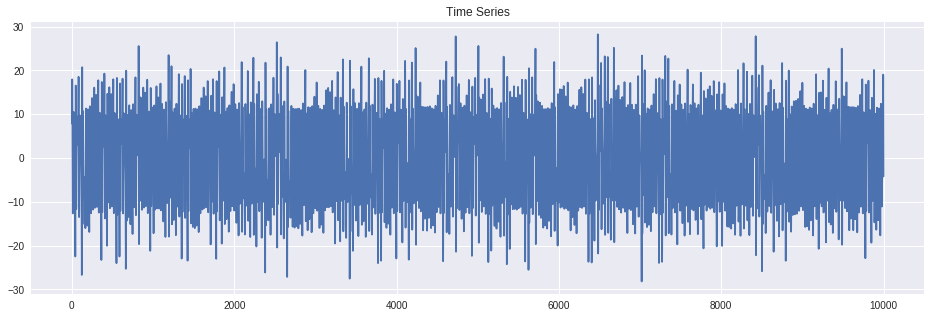

In [5]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("Chen Attractor Time Series")
plt.show()

In [6]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [8]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-2000]; out_sample = scaled_data[-2000:]
print(in_sample.shape)

(8000,)


In [0]:
in_sample = in_sample.reshape(-1,1)

#Empirical Mode Decomposition


In [10]:
!pip install EMD-signal
from PyEMD import EEMD 

    100% |████████████████████████████████| 163kB 6.7MB/s 
    100% |████████████████████████████████| 61kB 16.2MB/s 
    100% |████████████████████████████████| 112kB 30.6MB/s 
    100% |████████████████████████████████| 1.4MB 17.8MB/s 
  Running setup.py bdist_wheel for pathos ... - \ done
  Stored in directory: /root/.cache/pip/wheels/12/6b/3f/c9d2272bcd06caaf166988b27f72b7b08ab34ef211c8cbc4db
  Running setup.py bdist_wheel for ppft ... - \ done
  Stored in directory: /root/.cache/pip/wheels/6f/25/0d/a2099d51db6f2a7c6019599bd3b62795da3bf76a6a4eb0e615
  Running setup.py bdist_wheel for pox ... - done
  Stored in directory: /root/.cache/pip/wheels/16/f0/d1/d618f2d966cb9b219a87ef3eca40e369ef51462eb18ba9e8c5
  Running setup.py bdist_wheel for multiprocess ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/8b/36/e5/96614ab62baf927e9bc06889ea794a8e87552b84bb6bf65e3e
Successfully built pathos ppft pox multiprocess


In [11]:
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)

(8000, 1) (8000, 1)


In [12]:
imfs1 = eemd(in_sample, t)

print(imfs1.shape)

(16, 8000)


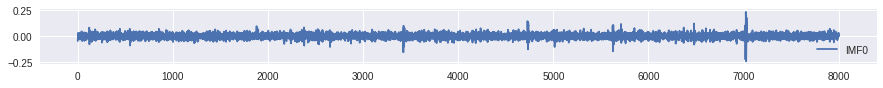

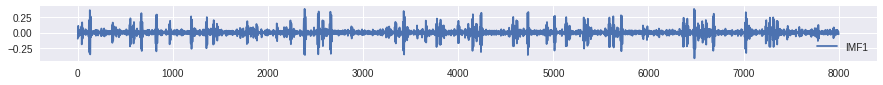

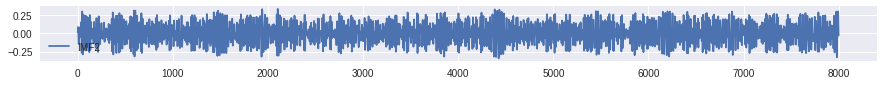

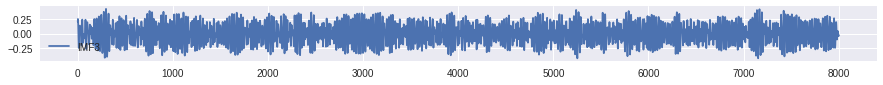

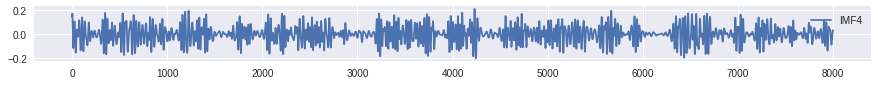

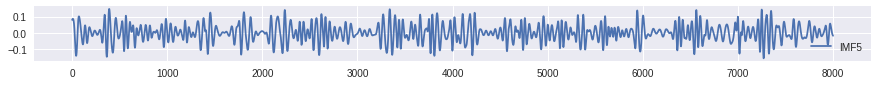

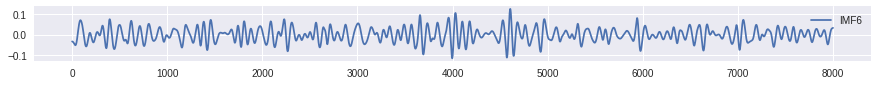

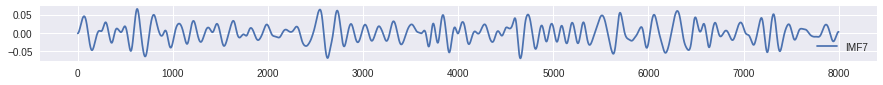

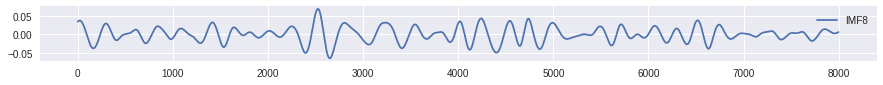

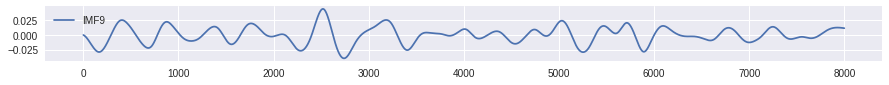

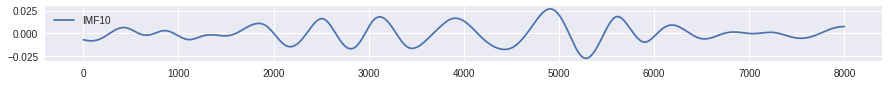

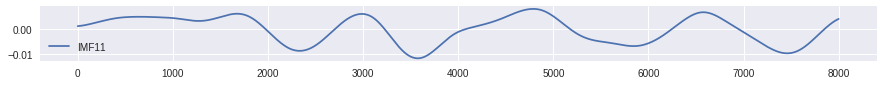

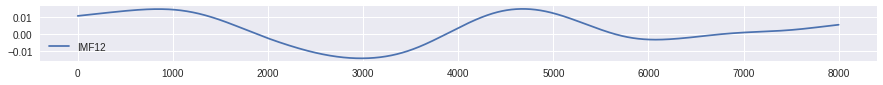

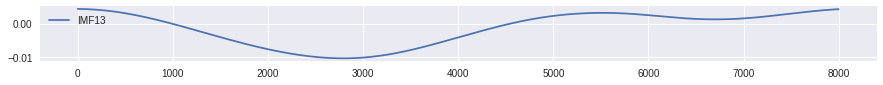

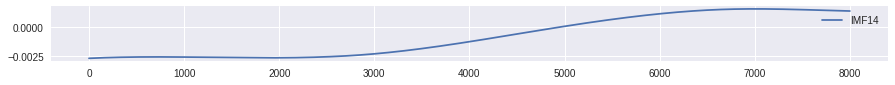

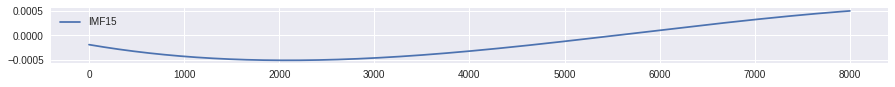

In [13]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(15,1))
  fig = plt.plot(imfs1[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

# Creating Datasets


*Raw Data, using lags = 20*

In [14]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(8000, 1)


In [0]:
lookback = 10
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [16]:
# this is the raw data, broken into sequences of 20 that result in sequence of 1.
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
print(Xr.shape)

(7990, 11)
(7990, 10)


# All IMFs

In [17]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); imfs1.shape

imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)
imf_df = np.reshape(imf_df, (7990, 11, 16))

print(imf_df.shape)

(7990, 1, 176)
(7990, 11, 16)


In [18]:
#so you want imf_df[:,-1,:]
targets = imf_df[:,-1,:]
print(targets.shape)

(7990, 16)


In [19]:
#so reshape everything properly
input_data = np.reshape(Xr, (7990, 1, 10))
targets = np.reshape(targets,(7990, 1, 16))
print(input_data.shape, targets.shape)

(7990, 1, 10) (7990, 1, 16)


In [0]:
#great everything is good 

In [20]:
#test Y values 

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = lookback, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testX = out_df[:,:-1]; testX = np.expand_dims(testX, axis = 1); print(testX.shape)
testY = out_df[:,-1]; print(testY.shape)

(1990, 11)
(1990, 1, 10)
(1990,)


# Partial autocorrelation 

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


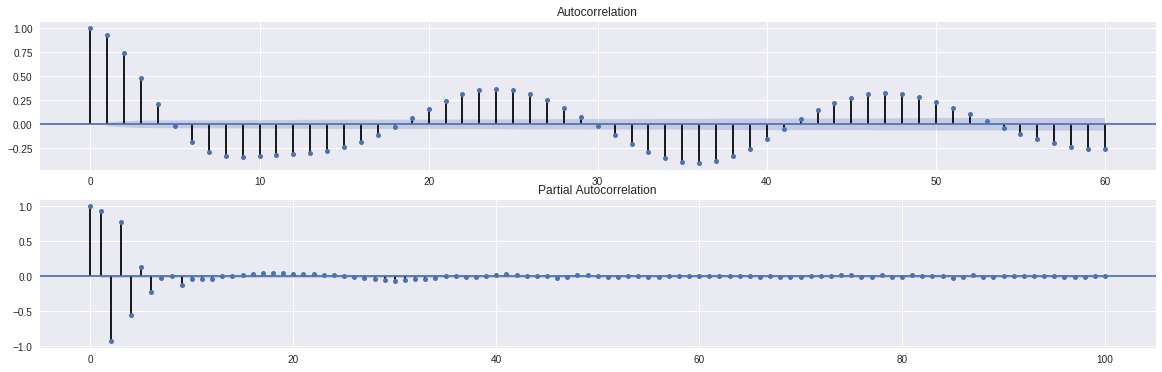

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

In [26]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import LeakyReLU
from keras import optimizers
np.random.seed(2018) #inputs are (1, 20) and outputs are #(1 time step,17 features)
pad = "causal"
inputs = Input(shape = (1, lookback))


x0 = Conv1D(128, 3, padding = pad, dilation_rate = 2, activation = "tanh", kernel_initializer = "glorot_uniform")(inputs)
x1 = Conv1D(128, 3, padding = pad, dilation_rate = 4, activation = "tanh", kernel_initializer = "glorot_uniform")(inputs)
#x2 = Conv1D(512, 2, padding = pad, dilation_rate = 16, activation = "tanh", kernel_initializer = "glorot_uniform")(inputs)
#x3 = Conv1D(512, 2, padding = pad, dilation_rate = 32, activation = "tanh", kernel_initializer = "glorot_uniform")(inputs)
#x4 = Conv1D(512, 2, padding = pad, dilation_rate = 64, activation = "tanh", kernel_initializer = "glorot_uniform")(inputs)
#x5 = Conv1D(512, 2, padding = pad, dilation_rate = 256, activation = "tanh", kernel_initializer= "glorot_uniform")(inputs)

x = concatenate([inputs, x0, x1])

predictions = Conv1D(16, 2, padding = pad, 
                     dilation_rate = 2, 
                     kernel_initializer = "glorot_uniform", 
                     activation = "tanh")(x)

model = Model(inputs = inputs, outputs = predictions)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-5, patience = 5, verbose = 1)

model.compile(optimizer = optimizers.Adadelta(lr = 1, clipnorm = .05), loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 20, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 10)        0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 1, 128)       3968        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1, 128)       3968        input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 1, 266)       0           input_2[0][0]                    
                                                                 conv1d_4[0][0]                   
          

In [27]:
predictions = model.predict(testX, batch_size = 1)
print(predictions.shape)

(1990, 1, 16)


(1990, 1)
(1990,)


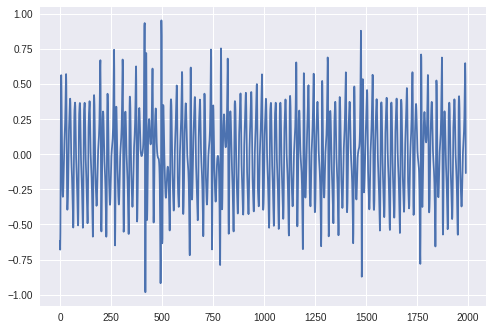

In [28]:
summed = np.sum(predictions, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds); print(test_preds.shape) #does this match the testY.shape

Final R2 Score is: 0.9734166693002106


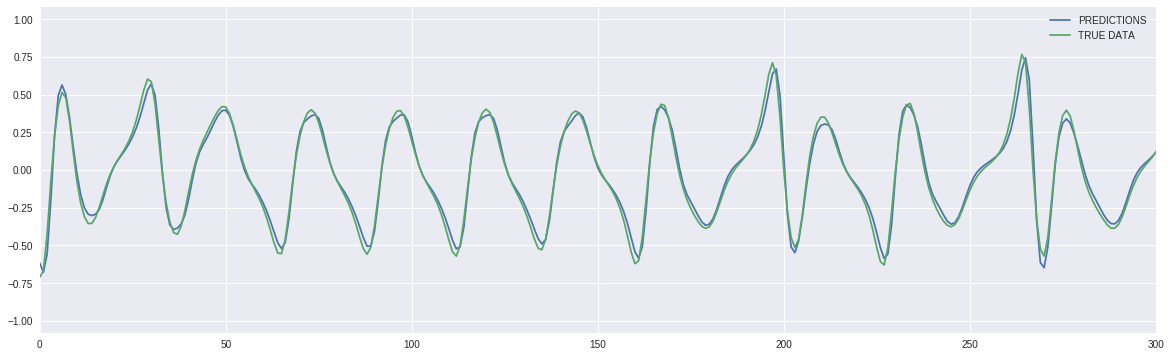

In [29]:
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))

fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0,300])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()